# import packages and read h5 files

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [ ]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
print(list(f1.keys()))

['data', 'depth', 'stamps', 'stamps_unix']


# Waterfall plot

In [3]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      'font.family':'Times New Roman',
      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [5]:
# Assign variables
dstrain = (f1['data'])
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

                  0
0          0.061537
1          0.396648
2          0.728532
3          1.063644
4          1.395478
...             ...
56757  18925.673828
56758  18926.009766
56759  18926.341797
56760  18926.675781
56761  18927.007812

[56762 rows x 1 columns]


In [91]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(9525, 56762)


In [92]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.33511138 0.3318844  0.33511144 ... 0.33203125 0.33398438 0.33203125]
0.3334498


In [93]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-01-13 09:45:01.254682
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 144.04695389248218


In [94]:
data = dstrain;

# creating a Data2D class instance

DASdata = Data2D_XT.Data2D() # initiate instance
DASdata.data = data.T   # DAS data in 2D array, the first axis is distance and second axis is time

# DASdata.taxis = pd.date_range(start = date_plot[0],end = date_plot[-1],periods = len(date_plot))
DASdata.taxis = t_axis

DASdata.daxis = np.arange(data.shape[1])*average_diff  # 1D array for distance grid, unit in ft
DASdata.start_time = startdate

DASdata.daxis[-1]
print(DASdata.data.shape)

(56762, 9525)


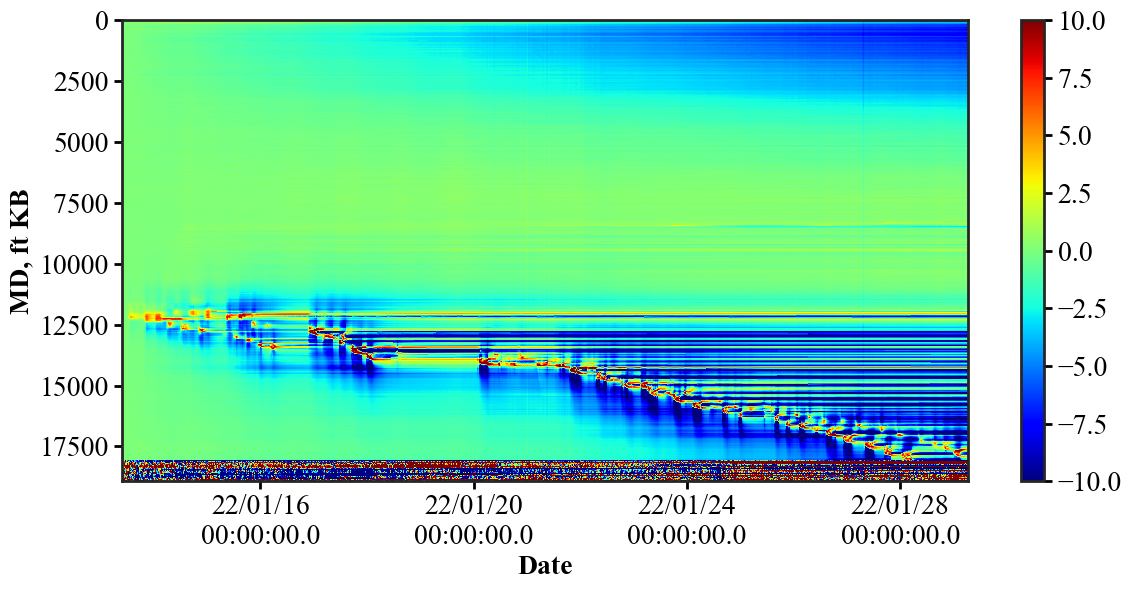

In [98]:
# cx = np.array([-1,1])
# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
DASdata.plot_waterfall(timescale='second',use_timestamp=True,cmap=plt.get_cmap('jet'),xtickN=5)
ax = plt.gca()
plt.clim(-10,10)
plt.colorbar()
plt.ylabel("MD, ft KB")
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('waterfall_ori.svg')


# Strain change v.s. Time at certain depths

In [4]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      'font.family':'Times New Roman',
      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [5]:
# Assign variables
dstrain = (f1['data'])
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
# print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

In [6]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(9525, 56762)


In [7]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.33511138 0.3318844  0.33511144 ... 0.33203125 0.33398438 0.33203125]
0.3334498


In [9]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-01-13 09:45:01.254682
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 144.04695389248218


In [20]:
start_MD = 30000 # Fiber range : 12000ft
end_MD = 53000 # Fiber range

chosenMD = (np.arange(5)-2)+(22173 + start_MD) #index
eltsMD = depth[:end_MD][chosenMD] 

In [21]:
cut = np.where(depth[0:-1] > 12000)[0]
print(len(cut))

20773


In [18]:
# Tricks of date plot
# startDate = datetime.datetime(2022,1,4,20,46,10)
# tdelta = np.ones(len(date_plot))*145 # 145 is the time interval

# t_date = []
# t_date.append(startDate)

# for i in range(1,len(tdelta)):
#     t_date.append(t_date[i-1] + datetime.timedelta(seconds = tdelta[i]))

# print(type(t_date))  # list
# print(type(dtimes))  # numpy.ndarray
# print(dtimes[0])
# print(t_date[0])
dtimes

array([datetime.datetime(2022, 1, 13, 9, 45, 1, 254682),
       datetime.datetime(2022, 1, 13, 9, 47, 24, 566709),
       datetime.datetime(2022, 1, 13, 9, 49, 48, 144389), ...,
       datetime.datetime(2022, 1, 29, 6, 45, 17, 22541),
       datetime.datetime(2022, 1, 29, 6, 47, 40, 881501),
       datetime.datetime(2022, 1, 29, 6, 50, 4, 443554)], dtype=object)

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\fengxiang.mao\AppData\Local\Temp\ipykernel_2380\1685038515.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Strain Change, $\mu\epsilon$',fontweight = 'bold',fontsize=20)


<Figure size 1200x600 with 0 Axes>

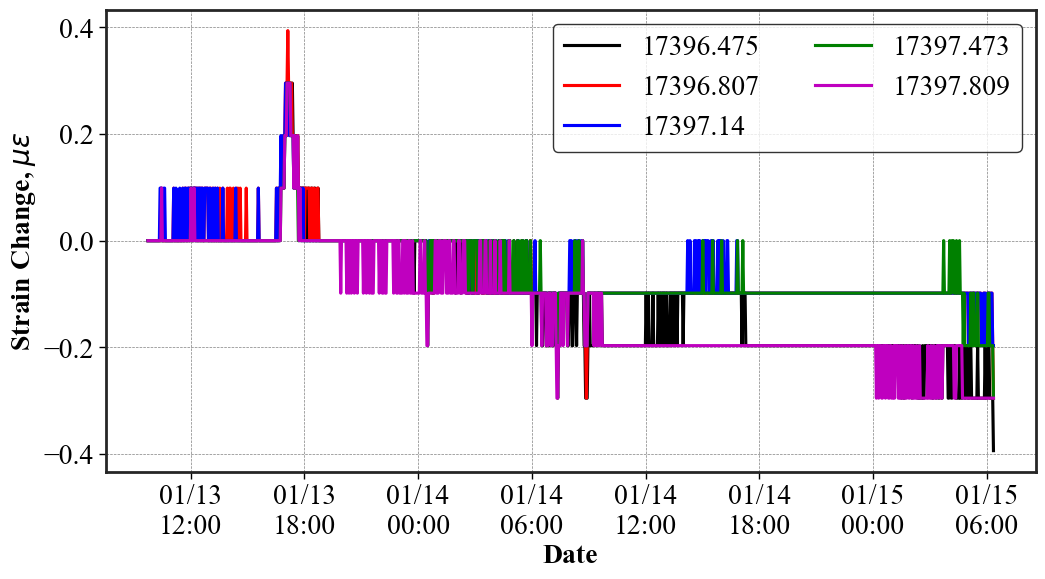

In [22]:
plt.figure()
fig, ax = plt.subplots(figsize = (12,6))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=1, length=5)

for i in range(len(chosenMD)):
    plt.plot(dtimes[:1120], dstrain[:1120,chosenMD[i]], linewidth = 2.25,label = eltsMD[i] )
    plt.xlabel("Date", fontweight = 'bold', fontsize=20)
    plt.ylabel('Strain Change, $\mu\epsilon$',fontweight = 'bold',fontsize=20)
    plt.legend(loc='best',ncol = 2,
               fontsize = 20, edgecolor = 'black')
# plt.plot(t_date[:1120],dstrain[:1120,52173])
plt.tick_params(axis='both', which='minor', labelsize=20)
ax.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tick_params(axis='both', which='major', labelsize=20, direction='out',
                top=False, right=False)
ax = plt.gca()
ax.xaxis_date()
date_format = mdates.DateFormatter('%m/%d\n%H:%M')
ax.xaxis.set_major_formatter(date_format)
# ax.tick_params(axis='x',labelrotation=45)
# plt.savefig(f'ori_chan{chosenMD[0]}.svg')